## Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [2]:
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import datetime as dt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
import xgboost as xgb

import os
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

## Reading data

In [3]:

# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

ModuleNotFoundError: No module named 'google.colab'

In [ ]:

#STEP-2: Autheticate E-Mail ID

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
#STEP-3: Get File from Drive using file-ID

#2.1 Get the file
downloaded = drive.CreateFile({'id':'10QDGTSI5PEV9e7CTpfzsXRpUwRIsJA-J'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.csv') 

In [ ]:
#STEP-3: Get File from Drive using file-ID

#2.1 Get the file
downloaded = drive.CreateFile({'id':'1gTfCTD3fz-3NJnfYLm59nZFN3WC3fzfD'}) # replace the id with id of file you want to access
downloaded.GetContentFile('df_fe_without_preprocessing_train.csv')

In [ ]:
#STEP-3: Get File from Drive using file-ID

#2.1 Get the file
downloaded = drive.CreateFile({'id':'1JncN1Fyt-ND_yZXOzqEfcRsYMTKqtu7Q'}) # replace the id with id of file you want to access
downloaded.GetContentFile('nlp_features_train.csv')

In [4]:
#getting required features(columns) from .csv files
all_nlp_features = pd.read_csv("nlp_features_train.csv",encoding='latin-1')#contains advanced features
all_basic_features = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')#conatins basic features
only_nlp_features = all_nlp_features.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
only_basic_features = all_basic_features.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
simple_features = all_nlp_features[['id','question1','question2']]
actual_y = all_nlp_features.is_duplicate

In [5]:
only_nlp_features.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [6]:
only_basic_features.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [7]:
simple_features.head()

,id,question1,question2
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,3,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...
4,4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water


In [8]:
print("Number of features in nlp dataframe :", all_nlp_features.shape[1])
print("Number of features in preprocessed dataframe :", all_basic_features.shape[1])

Number of features in nlp dataframe : 21
Number of features in preprocessed dataframe : 17


# Preprocessing Data

In [9]:
#https://github.com/krpiyush5/Quora-Question-Pair-Similarity-Problem-/blob/master/final_update_QuoraQuestionPair.ipynb
simple_features = simple_features.fillna(' ')
new_df = pd.DataFrame()#creating new dataframe with columns question(q1+q2)
new_df['questions'] = simple_features.question1 + ' ' + simple_features.question2
new_df['id'] = simple_features.id
only_basic_features['id']=only_nlp_features['id']
new_df['id']=only_nlp_features['id']
final_df = only_nlp_features.merge(only_basic_features, on='id',how='left') #merging basic features and advanced features on id
X  = final_df.merge(new_df, on='id',how='left')#merging final_df and new_df

In [10]:
#There is no use of id so remove id from X
X=X.drop('id',axis=1)
X.columns
y=np.array(actual_y)

In [11]:
#splitting data into train(70%) and test(30%)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=3,test_size=0.3)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(283003, 27)
(283003,)
(121287, 27)
(121287,)


In [12]:
#seperating questions for tfidf vectorizer
X_train_ques=X_train['questions']
X_test_ques=X_test['questions']

X_train=X_train.drop('questions',axis=1)
X_test=X_test.drop('questions',axis=1)

## Featurizing text data with tfidf weighted word-vectors 

In [13]:
#vectorizing questions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf_vec = TfidfVectorizer(lowercase=False )
tfidf_vec.fit_transform(X_train_ques)

# dict key:word and value:tf-idf score
tfidf_word_vec = dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_))

In [29]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
#train dataset Avg tf-idf W2V
nlp = spacy.load('en_core_web_sm')
q_train_vectors = []
for question in tqdm(list(X_train_ques)):
    doc = nlp(question) 
    # 384 is the number of dimensions of vectors 
    mean_qtrain_vec = np.zeros([len(doc), 96])
    for word in doc:
        # word2vec
        vector = word.vector
        # fetch df score
        try:
            idf = tfidf_word_vec[str(word)]
        except:
            idf = 0
        mean_qtrain_vec += vector * idf
    mean_qtrain_vec = mean_qtrain_vec.mean(axis=0)#taking average(mean)
    q_train_vectors.append(mean_qtrain_vec)

100%|██████████| 283003/283003 [40:48<00:00, 115.58it/s]


In [15]:
#can we save vectors to a file and load them
#https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/
import h5py
#with h5py.File('q1_vectors.hdf5', 'w') as f:
#  dset = f.create_dataset("default", data=q1_vectors)
f = h5py.File('q1_vectors.hdf5', 'r')
q1 = f['default'][:]
f.close()

In [31]:
q_test_vectors = []
for question in tqdm(list(X_test_ques)):
    doc = nlp(question) 
    # 384 is the number of dimensions of vectors 
    mean__qtest_vec = np.zeros([len(doc), 96])
    for word in doc:
        # word2vec
        vector = word.vector
        # fetch df score
        try:
            idf = tfidf_word_vec[str(word)]
        except:
            idf = 0
        mean__qtest_vec += vector * idf
    mean__qtest_vec = mean__qtest_vec.mean(axis=0)#taking average(mean)
    q_test_vectors.append(mean__qtest_vec)

100%|██████████| 121287/121287 [17:02<00:00, 118.65it/s]


In [17]:
#https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/
#import h5py
#with h5py.File('q_test_vectors.hdf5', 'w') as f:
#    dset = f.create_dataset("default", data=q_test_vectors)
f = h5py.File('q2_vectors.hdf5', 'r')
q2 = f['default'][:]
f.close()

In [18]:
q_train_df=pd.DataFrame(q1)
q_test_df=pd.DataFrame(q2)

In [19]:
print(q_train_df.shape)
q_test_df.shape

(283003, 96)


(121287, 96)

In [20]:
from scipy.sparse import hstack
X_wtfidf_train = hstack((X_train.values,q_train_df))
X_wtfidf_test= hstack((X_test.values,q_test_df))
print(X_wtfidf_train.shape)
print(X_wtfidf_test.shape)

(283003, 122)
(121287, 122)


## Featurizing text data with tfidf word-vectors 

In [18]:
#tfidf vectorizer
tfidf = TfidfVectorizer()
X_train_q=tfidf.fit_transform(X_train_ques)
X_test_q=tfidf.transform(X_test_ques)

#adding tfidf features to our train and test data using hstack
X_tfidf_train = hstack((X_train.values,X_train_q))
X_tfidf_test= hstack((X_test.values,X_test_q))
print(X_train.shape)
print(X_test.shape)

(283003, 26)
(121287, 26)


In [19]:
from collections import Counter
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6296541026066862 Class 1:  0.37034589739331386
---------- Distribution of output variable in train data ----------
Class 0:  0.3665190828365777 Class 1:  0.3665190828365777


## plot function

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))
   
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Applying Models

## XGBOOST with Hyperparameter tuning on tf-idf Avgw2v


In [ ]:
#cross validation using randomsearch

from sklearn.model_selection import RandomizedSearchCV
params = {"max_depth":[1,5,10,50,100],
              "n_estimators":[x for x in range(0,501,50)]}
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
xgb_model = RandomizedSearchCV(model, param_distributions=params,n_iter=20,scoring='neg_log_loss',cv=3)
xgb_model.fit(X_wtfidf_train,y_train)

In [ ]:
#to get best hyperparameters
print("Model Score = ",xgb_model.best_score_)
print("Best Params = ",xgb_model.best_params_)

In [ ]:
best_depth = 5
best_estimators = 100
clf = xgb.XGBClassifier(max_depth=best_depth,objective='binary:logistic',n_estimators=best_estimators,n_jobs=-1)
clf.fit(X_wtfidf_train, y_train)

In [0]:
#https://chrisalbon.com/machine_learning/naive_bayes/calibrate_predicted_probabilities/
#https://github.com/abhikumar22/Quora-Question-Pair-Similarity/blob/master/5.Extensions.ipynb
cal_clf = CalibratedClassifierCV(clf, method="sigmoid")
cal_clf.fit(X_wtfidf_train, y_train)
predict_y = cal_clf.predict_proba(X_wtfidf_train)

print("Log loss [Train] : ",log_loss(y_train, predict_y,  eps=1e-15))
predict_y = cal_clf.predict_proba(X_test)
print("Log loss [Test] : ",log_loss(y_test, predict_y,  eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8849935238604291


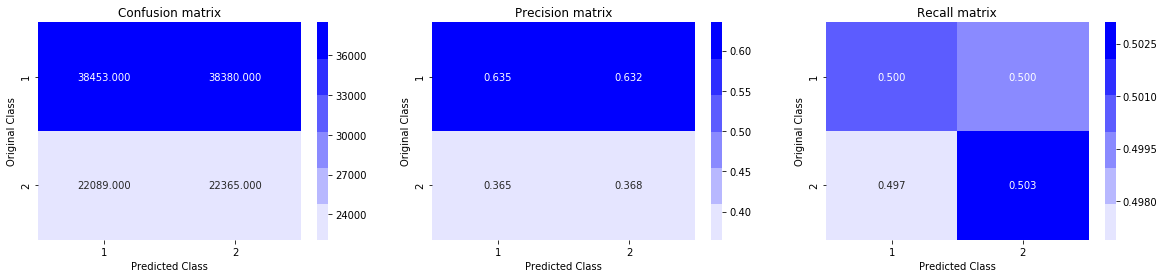

In [21]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
import numpy as np
import matplotlib.pyplot as plt
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

Observations:
from the above execution it is clear that max value of log loss can be 0.88 
so our models need to have significantly less log loss than 0.88

## Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.3978305344704581
For values of alpha =  0.0001 The log loss is: 0.392153959474439
For values of alpha =  0.001 The log loss is: 0.4204015148028563
For values of alpha =  0.01 The log loss is: 0.44286997289466357
For values of alpha =  0.1 The log loss is: 0.45908766610182566
For values of alpha =  1 The log loss is: 0.4926164311026623
For values of alpha =  10 The log loss is: 0.5448700347042517


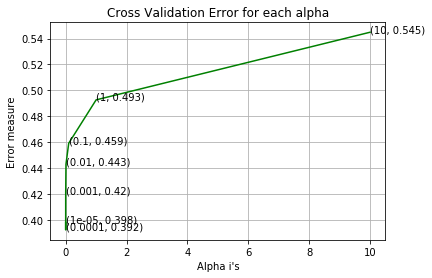

For values of best alpha =  0.0001 The train log loss is: 0.39166392993060906
For values of best alpha =  0.0001 The test log loss is: 0.392153959474439
Total number of data points : 121287


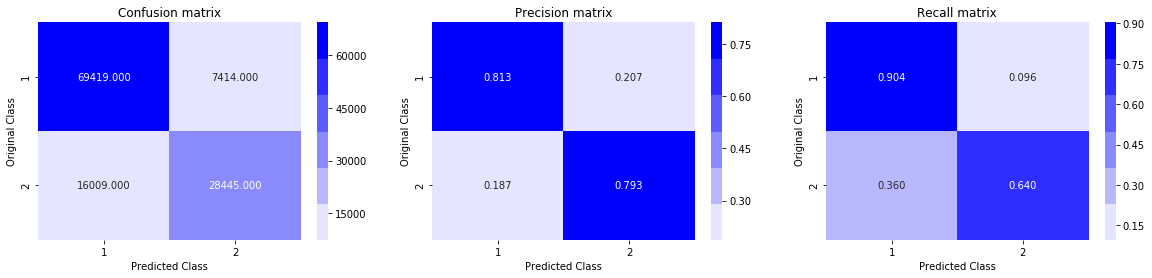

In [22]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_tfidf_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tfidf_train, y_train)
    predict_y = sig_clf.predict_proba(X_tfidf_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_tfidf_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tfidf_train, y_train)

predict_y = sig_clf.predict_proba(X_tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

Observations:
After applying Logistic Regression with hyperparameter tuning we have found that best alpha value is 0.0001 and test loss is 0.392 which is less than log loss of random model but it is near to log loss value of random model so we can say that model is not performing that well 
And train and test loss are almost same we can say that our model is not overfitting  but it may be underfitting

## Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.4208379449437567
For values of alpha =  0.0001 The log loss is: 0.43416261866928535
For values of alpha =  0.001 The log loss is: 0.4584949724917893
For values of alpha =  0.01 The log loss is: 0.507502478793165
For values of alpha =  0.1 The log loss is: 0.4949522896309145
For values of alpha =  1 The log loss is: 0.5790224258771397
For values of alpha =  10 The log loss is: 0.6216484119939985


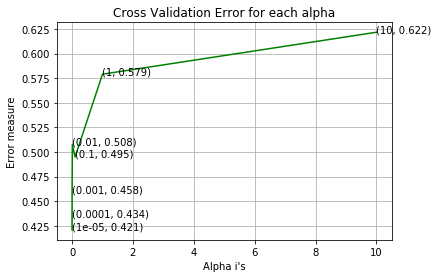

For values of best alpha =  1e-05 The train log loss is: 0.41764871102458306
For values of best alpha =  1e-05 The test log loss is: 0.4208379449437567
Total number of data points : 121287


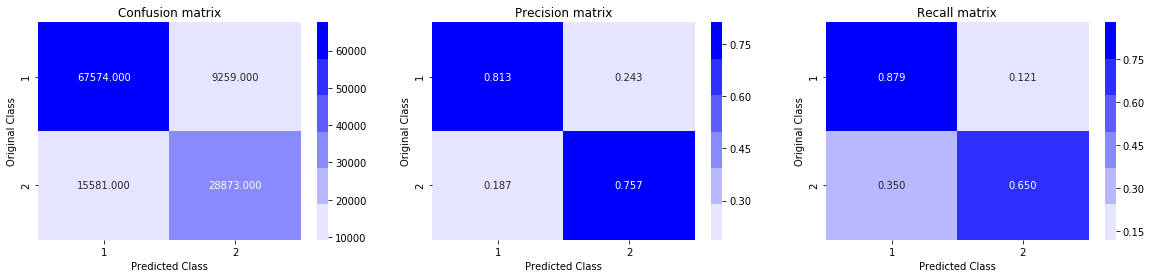

In [26]:
#parameters:- penality=l1,loss=hinge
alpha = [10 ** x for x in range(-5, 2)] 
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_tfidf_train, y_train)
    #https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tfidf_train, y_train)
    predict_y = sig_clf.predict_proba(X_tfidf_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_tfidf_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tfidf_train, y_train)

predict_y = sig_clf.predict_proba(X_tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

Observations:
After applying Linear SVM  with hyperparameter tuning we have found that best alpha value is 0.00001 and test loss is 0.42 which is less than log loss of random model 
And train and test loss are almost same we can say that our model is not overfitting  but it may be underfitting

Linear SVM is performing well than Logistic Regression

# Summary

In [27]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["model", "Hyperparameter", "Log loss"]
x.add_row(["Random(tfidf)", 0, 0.88])
x.add_row(["Logistic Regression(tfidf)", 0.0001, 0.392])
x.add_row(["Linear SVM(tfidf)", 0.00001, 0.42])
x.add_row(["XGBoost(avgw2v-tfidf)", "depth=5,n_estimators=100", "0.08*10^-3"])
print(x)

+---------------------+--------------------------+------------+
|        model        |      Hyperparameter      |  Log loss  |
+---------------------+--------------------------+------------+
|        Random       |            0             |    0.88    |
| Logistic Regression |          0.0001          |   0.392    |
|      Linear SVM     |          1e-05           |    0.42    |
|       XGBoost       | depth=5,n_estimators=100 | 0.08*10^-3 |
+---------------------+--------------------------+------------+


# Process:

1.   imported the necessary libraries
2.   imported 3 files which contains simple features and advanced features and questions
3.   split the data into train and test and then seperated questions from the data
1.   vectorized them using tfidf
2.   combined the vectors into respective train and test sets 
1.   applyed XGBoost with hyperparameter Tuning 
1.   vectorized them using tfidf and then calculated avg-w2v tf-idf of the questions
1.   combined the vectors into respective train and test sets 
2.   Built a  random model which predicts y labels randomly for getting maximum possible log-loss
1.   did fine tuning using own loop applyed Logistic Regression on tf-idf features set and found best parameters and found the model log-loss value
2.   Similarly did finetuning and applied linear SVM on tf-idf features set and got the log-loss value 
1.   lastly summarized the results using pretty table







